In [66]:
import matplotlib.pyplot as plt
from t4gpd.io.CirReader import CirReader
from t4gpd.pyvista.ToUnstructuredGrid import ToUnstructuredGrid
from shapely.geometry import Polygon
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
import geopandas

In [67]:
gdf = CirReader("C:/Users/zcui/Desktop/programming/Re_ Rnion bilan GLO dans le SIG/scene_masque.cir").run()

In [140]:
gdf3d = ToUnstructuredGrid(gdf).run()
gdf3d.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [68]:
basemap_x=[]
basemap_y=[]
basemap_z=[]
sidewall_x=[]
sidewall_y=[]
sidewall_z=[]
for i in range(len(gdf)):
    f = gdf.geometry[i]
    fig = Polygon(f)
    x, y, z=zip(*fig.exterior.coords)
    #if sum(z)==0:
    
    if np.std(z)==0:
        basemap_x.append(x)
        basemap_y.append(y)
        basemap_z.append(z)
    else:
        sidewall_x.append(x)
        sidewall_y.append(y)
        sidewall_z.append(z)

In [69]:
elevation = []
for i in range(len(basemap_z)):
    elevation.append(np.mean(basemap_z[i]))
df = GeoDataFrame({'HAUTEUR':elevation})
df['gid'] = df.index+1

In [70]:
#lable
lable = []
for i in range(len(df)):
    if df.HAUTEUR[i]==0:
        lable.append("Ground")
    else:
        lable.append("Building")
df['Lable'] = lable

In [71]:
#geometry
#geometry
geometry =[]
for i in range(len(df)):
    p = Polygon(list(zip(basemap_x[i],basemap_y[i])))
    geometry.append(p)
df['geometry'] = geometry

_difference = df.geometry[0]#create ground with holes
for i in range(1,len(df)):
    _difference = _difference.difference(df.geometry[i])
df.at[0,'geometry']=_difference

In [72]:
#floor
floor = []
for i in range(len(df)):
    n=0
    if df.Lable[i] == 'Ground':
        floor.append(0)
    else:
        for j in range(len(sidewall_x)):
            q = Polygon(list(zip(sidewall_x[j],sidewall_y[j])))
            if df.geometry[i].contains(q):
                n = n+1
        nmb = len(basemap_x[i])-1
        floor.append(n/nmb)
df['floor'] = floor
df

,HAUTEUR,gid,Lable,geometry,floor
0,0.0,1,Ground,"POLYGON ((-30.000 120.000, 120.000 120.000, 12...",0.0
1,18.0,2,Building,"POLYGON ((70.000 50.000, 70.000 70.000, 50.000...",6.0
2,18.0,3,Building,"POLYGON ((25.000 0.000, 25.000 20.000, 5.000 2...",6.0
3,30.0,4,Building,"POLYGON ((20.000 65.000, 40.000 65.000, 40.000...",10.0
4,30.0,5,Building,"POLYGON ((95.000 70.000, 95.000 90.000, 75.000...",10.0
5,30.0,6,Building,"POLYGON ((65.000 5.000, 65.000 25.000, 85.000 ...",10.0
6,36.0,7,Building,"POLYGON ((60.000 80.000, 60.000 100.000, 40.00...",12.0
7,42.0,8,Building,"POLYGON ((100.000 60.000, 100.000 40.000, 80.0...",14.0
8,42.0,9,Building,"POLYGON ((20.000 75.000, 20.000 95.000, 0.000 ...",14.0
9,24.0,10,Building,"POLYGON ((35.000 40.000, 35.000 20.000, 55.000...",8.0


In [73]:
from t4gpd.morph.geoProcesses.STGeoProcess import STGeoProcess
from t4gpd.morph.geoProcesses.SkyViewFactor import SkyViewFactor
from t4gpd.morph.STPointsDensifier2 import STPointsDensifier2

In [137]:
#sensors on the buildings
df_buildings = GeoDataFrame.copy(df)#Here I create a copy value of df for puting sensors
df_buildings.drop(df_buildings.index[df_buildings['Lable'] == 'Ground'], inplace = True)
sensors = STPointsDensifier2(df_buildings, curvAbsc=[0.25,0.5,0.75], pathidFieldname=None).run()
sensors.floor = sensors.floor.astype(int)

In [143]:
#create sensors in each floor level
from t4gpd.commons.GeomLib import GeomLib\

rows = []
for _,row in sensors.iterrows():
    for nfloor in range(row.floor):
        _row = row.copy()
        _row.geometry = GeomLib.forceZCoordinateToZ0(_row.geometry,nfloor*3.0+1.5)
        rows.append(_row)
sensors2 = GeoDataFrame(rows,crs=sensors.crs)
type(sensors2)

geopandas.geodataframe.GeoDataFrame

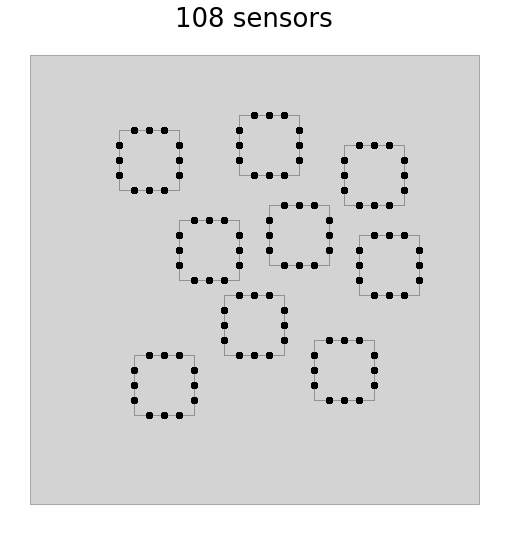

In [146]:
#plot
fig, basemap = plt.subplots(figsize=(1.5 * 8.26, 1.1 * 8.26))
basemap.set_title(f'{len(sensors)} sensors', size=26)
df.plot(ax=basemap, color='lightgrey', edgecolor='dimgrey', linewidth=0.5)
sensors2.plot(ax=basemap, color='black')
basemap.axis('off')
plt.show()